# Lab assignment: SVMs in scikit-learn

In this assignment we will learn how to work with SVMs using the scikit-learn library. We will study in detail their cross-validation, pipelining, training times and kernel functions.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>This is an advanced and voluntary exercise that can help you gain a deeper knowledge into the topic. Good luck!</td></tr>
</table>


During the assignment you will make use of several Python packages that might not be installed in your machine. If that is the case, you can install new Python packages with

    conda install PACKAGENAME
    
if you are using Python Anaconda. Else you should use

    pip install PACKAGENAME

You will need the following packages for this particular assignment. Make sure they are available before proceeding:

* **numpy**
* **matplotlib**
* **scikit-learn**

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells.

Let's go!

## Synthetic dataset

For the first exercises of this assignment we will use the synthetic dataset generated by the following code:

In [2]:
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
RND_STATE=np.random.RandomState(42)
# Build first cluster
X1, y1 = make_gaussian_quantiles(cov=2., n_samples=200, n_features=2, n_classes=2, random_state=RND_STATE)
# Build second cluster
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=RND_STATE)
# Fuse them, scaling features differently and switching labels of y2
X = np.concatenate((X1, X2))
X[:, 0] *= 10
X[:, 1] /= 10
y = np.concatenate((y1, -y2+1))

The dataset consists of 500 points and consists of two Gaussian clusters. In each cluster points in its inner circle belong to one class, and those in the outer circle belong to the other class. Classes are switched in the second cluster so that it is more challenging to discriminate between both classes.

If we plot these data we obtain the following:

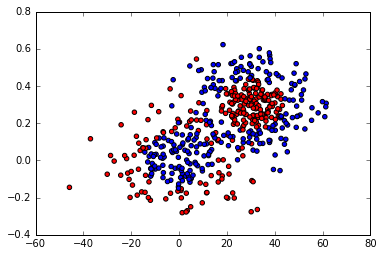

In [3]:
from matplotlib.colors import ListedColormap
cm = ListedColormap(['#0000FF', '#FF0000'])    # blue, red
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm)     
plt.show()

Once we have generated the data *(X, y)*, let us split them into a **training set** and a **test set**. There is a utility function in scikit-learn that does exactly this:

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RND_STATE)

/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Since *test_size=0.5*, both the training set and the test set will have 250 points each. The number of features is 2, as specified when invoking *make_gaussian_quantiles*:

In [5]:
print(X_train.shape)
print(X_test.shape)

(250, 2)
(250, 2)


## Scikit-learn basics

Scikit-learn's models for **supervised learning** (SVMs are just one kind of such models) implement a common interface. The most important functions of this interface are the following:

* **fit(X, y)**: trains the model, fitting it for input patterns *X* and outputs *y*.
* **score(X, y)**: tests an already fitted model with additional data, returning the accuracy obtained (i.e., how similar the outputs given by the model are, compared to the true outputs *y*).

Thus, all classifiers and regressors in scikit-learn have specific implementations for the above functions. The differences among models (e.g., the different parameters they use) are treated either during construction or internally within these functions.

For the particular case of SVMs for classification, the implementing class is <a href=http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html>SVC</a>:

In [6]:
from sklearn.svm import SVC
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

As you can see, by default scikit-learn builds an SVM with the **RBF kernel**. We know that such an SVM needs 2 parameters: **C** (regularizer between model complexity and classification errors) and **gamma** (kernel width). These are set to 1 and to 'auto' respectively, where 'auto' stands for 1/d (that is, 1 divided by the number of features).

If you want to create an instance of an SVM with other values for these parameters, you just specify them (the rest of options for the constructor can be safely ignored for now):

In [7]:
SVC(C=5, gamma=0.01)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In practice it is difficult to know which values for *C* and *gamma* work best for a particular dataset. This is why it is common to try with a **grid** of values for both parameters, selecting the pair of values that result in the highest accuracy.

The first step is selecting the parameter **ranges**. For this exercise, let us use these:

In [8]:
Cs = np.logspace(-2, 4, 7)
gammas = np.logspace(-4, 4, 9)

That is, *C* ranges from 0.01 to 10000, whereas *gamma* goes from 0.0001 to 10000, using powers of 10 as intermediate values.

Recall that in order to avoid **overfitting**, we cannot use the test set for **tuning** these parameters. The following code keeps track of the accuracies obtained for the training set, selecting the best *C* and *gamma*:

In [9]:
# Accuracies
accs = np.zeros((len(Cs), len(gammas)))   # all accuracies (in matrix form)
best_acc = 0.0   # best accuracy
# For each C
for i, C in enumerate(Cs):
    # For each sigma
    for j, gamma in enumerate(gammas):
        # Create and train SVM
        svm = SVC(C=C, gamma=gamma).fit(X_train, y_train)
        # Keep track of accuracies and best params
        acc = svm.score(X_train, y_train)
        accs[i, j] = acc
        if acc > best_acc:
            best_C = C
            best_gamma = gamma
            best_acc = acc

It is illustrative to plot these accuracies in matrix form:

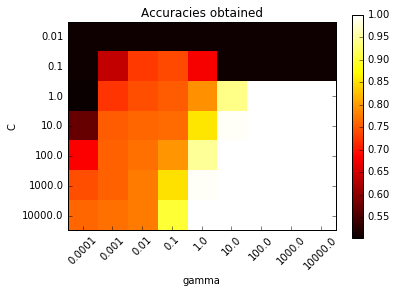

In [10]:
plt.imshow(accs, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), gammas, rotation=45)
plt.yticks(np.arange(len(Cs)), Cs)
plt.title('Accuracies obtained')
plt.show()

The best parameters turn out to be:

In [11]:
print("Best C = " + str(best_C))
print("Best gamma = " + str(best_gamma))

Best C = 1.0
Best gamma = 100.0


Which give a perfect accuracy on the training set:

In [12]:
print("Best accuracy on train = " + str(best_acc))

Best accuracy on train = 1.0


In [13]:
print("accuracy on test =%4.3f " %(svm.score(X_test,y_test)))

accuracy on test =0.492 


## Cross-validation

Perfect accuracy may seem like great news. However, the performance on the test set is not so good:

In [14]:
best_model = SVC(C=best_C, gamma=best_gamma).fit(X_train, y_train)
best_model.score(X_test, y_test)

0.628

This is a clear sign of overfitting on the training set. If you remember from the theory, ideally we should tune our model fitting it with the training set, but assessing performance on a separate set called **validation set**.

However, usually there are not enough data to split them into separate training, validation and test sets. If that is the case, we can resort to **cross-validation**, which proceeds as follows:
* The training set is partitioned into *k* subsets (called **folds**).
* *k* different models are trained, using each of the *k* folds to assess performance and the remaining *k-1* folds to fit each model.
* The best model is that whose average performance on the *k* folds is best.

Programming all this is laborious. Fortunately, the team behind scikit-learn have a whole <a href=http://scikit-learn.org/stable/modules/cross_validation.html>cross-validation module</a>. In addition, the library also has a class specifically designed to perform grid search on the parameters you specify, which is called <a href=http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html>GridSearchCV</a>:

In [15]:
from sklearn.grid_search import GridSearchCV

/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


As the documentation states, in order to build an instance of *GridSearchCV*, you will need to specify two objects:
* An **estimator**, that is, the internal model that is optimized (in this case an *SVC* instance).
* A **parameter grid**, a dictionary where you specify the parameter names and the ranges to perform the search on (these ranges were defined above).

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Use the code cell below to create a *GridSearchCV* object called *gs* with the SVM as estimator and the range for *C* and *gamma* we defined above.
 </td></tr>
</table>

In [16]:
param_grid_svm = [{'C':Cs,
                  'gamma': gammas,
                  'kernel': ['rbf']}]   

#we run all the models, with Cross Validation parameter set to 10   
gs_svm = GridSearchCV( SVC(),
                          param_grid=param_grid_svm,
                          scoring="accuracy",
                          cv=5,
                          n_jobs=-1,
                          verbose=1)

GridSearchCV is implemented as well as a model, so its fit(X, y) method is the one that performs the grid search, doing cross-validation under the hood.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Call the fit method on your *gs* object to perform the grid search on the training set. Do not worry if it takes some time to complete. 
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
If you build your *GridSearchCV* object above with *verbose=1* you will see a trace of how the cross-validation process is going. For more details, set *verbose=2*. If your PC has several processors you can speed up the whole process by setting *n_jobs* accordingly.
 </td></tr>
</table>

In [17]:
gs_svm.fit(X,y)   

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:   10.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'gamma': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04]), 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04]), 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

Now that the grid search is complete, let us recover the results obtained. To keep things as before, we would like to overwrite the following variables:
* *accs*: accurary matrix for the different (*C*, *gamma*) pairs.
* *best_acc*: best accuracy.
* *best_C*: best value for *C*.
* *best_gamma*: best value for *gamma*.
* *best_model*: fitted model with the best *C* and the best *gamma*.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Recover these variables from the fitted *gs* object. Check the *attributes* section in the <a href=http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html>documentation</a>.
 </td></tr>
</table>

In [18]:
print("best Score",gs_svm.best_score_)
print("Best parameters :")
print(gs_svm.best_params_)
   

best Score 0.74
Best parameters :
{'gamma': 0.0001, 'C': 10000.0, 'kernel': 'rbf'}


<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
You do not need to retrain *best_model* from *best_C* and *best_gamma*, it is available directly in the *best\_estimator\_* attribute (notice the final underscore). Think also about how to get the accuracies in matrix form from *grid\_scores\_*. Numpy's *reshape* function may come in handy.
 </td></tr>
</table>

In [19]:

_scores=np.array([x[1] for x in gs_svm.grid_scores_]).reshape(len(Cs),len(gammas))



<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Replot the accuracies just retrieved. In what way is the resulting figure different from the previous one?
 </td></tr>
</table>

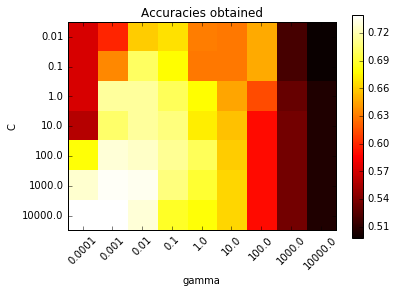

In [20]:
plt.imshow(_scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), gammas, rotation=45)
plt.yticks(np.arange(len(Cs)), Cs)
plt.title('Accuracies obtained')
plt.show()

we obtain a complete different plot due to cross validation and test scores instead of only dealing with training scores as  we did before

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Reprint the best parameters and their accuracy on training. Explain the changes you observe.
 </td></tr>
</table>

In [21]:
print("best Score",gs_svm.best_score_)
print("Best parameters :")
print(gs_svm.best_params_)

best Score 0.74
Best parameters :
{'gamma': 0.0001, 'C': 10000.0, 'kernel': 'rbf'}


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Recalculate the accuracy on test. Dit it improve?
 </td></tr>
</table>

In [22]:
gs_svm.score(X_test, y_test)

/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.73599999999999999

yes: we get 0.736 versus 0.492

## Pipelining

So far we have assumed that, once the data are loaded, they are ready to be fed to our model without any changes. If you inspect the code above, there is no change in the dataset since creation till it is fed to the *fit(X, y)* method (note that splitting the patterns in validation folds does not change the patterns themselves).

In practice this will rarely be the case. The data usually need some kind of previous transformations, such as making them all be uniform. This is what is known as **preprocessing**. Combining these transformations with other processes like cross-validation is tricky, as one must make sure that the transformations take place in each of the validation folds, so that the models are only fitted with properly transformed data.

Once more, we are lucky that scikit-learn makes this task very easy. The class that encapsulates all this is called <a href=http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html>Pipeline</a>:

In [23]:
from sklearn.pipeline import Pipeline

Conceptually, a pipeline is defined as a series of **transformers**, followed by one final step which must be an estimator. In the scikit-learn's jargon, this means that the class that takes the last step must implement the method *fit(X, y)*, whereas all the previous classes must implement a new method called *transform(X)* that makes some modification on the input data *X*. If those transformations are data-dependent and have to be learnt, they must also implement another method called *fit_transform(X, y)*.

Scikit-learn hides this complexity by implementing Pipeline itself as a model as well. Thus, this class complies with the interface we saw in the previous section: 
* **fit(X, y)**: calls *fit_transform(X, y)* for all transformers, then calls *fit(X, y)* for the final estimator. This means that all transformations are successively learnt and applied before fitting the model with the properly transformed data.
* **score(X, y)**: calls *transform(X)* for all transformers, then calls *score(X, y)* for the final estimator. The final model requires transformed data, and all the transformations have been learnt by *fit(X, y)*, so they can be now applied directly.

As the <a href=http://scikit-learn.org/stable/modules/pipeline.html>usage guide</a> describes, in order to build an instance of <a href=http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html>Pipeline</a> you will need to specify a list of **steps**, that is, the transformers and the final estimator you wish to chain. For internal reference, each of these steps must be identified by a name as well as by its class, so the steps are passed as a list of (name, class) pairs. Consider the following example:

In [24]:
Pipeline([('svm', SVC())])

Pipeline(steps=[('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Which builds a pipeline with just one estimator (the default SVM), named 'svm'. 

Obviously, a pipeline makes sense only when there is more than a single step. To keep things simple, here we will add just one previous step before the SVM, which performs **normalization to zero mean and unit variance**. This is carried out by the class <a href=http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html>StandardScaler</a>:

In [25]:
from sklearn.preprocessing import StandardScaler

This normalization makes all features be in the same scale, preventing that some feature may have a bigger influence than others just because of the different original scales. If you go back to the dataset's plot, you can see that the scale of the first coordinate is much larger than the second one ([-40, +60] range compared to [-0.3, +0.6]). If we applied an RBF SVM to the data as they are, when computing the kernel function the second coordinate would be negligible compared to the first one. 

However, the figure makes clear that both features are equally important for correct classification, so normalization should improve accuracies considerably. Let us see if this is indeed the case.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Build a pipeline called *pl* with a *StandardScaler* followed by an SVM. Name both steps as you please.
 </td></tr>
</table>

In [26]:
# Lo primero será generar un RFECV para seleccionar variables,
# que utilizará un árbol regresor sencillo para ver qué variables
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV

arbol_seleccionar = DecisionTreeRegressor()
rfecv = RFECV(estimator=arbol_seleccionar)
scaler = StandardScaler()
svm = SVC()

pl = Pipeline(steps=[("seleccionador",rfecv),("escalador",scaler), ("svm",svm)])



Performing grid search is trivial now, since *pl* is a valid estimator for the *GridSearchCV* object.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Rewrite the grid search for the pipeline. This should overwrite again the variables *accs*, *best_acc*, *best_C*, *best_gamma* and *best_model*.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Since the pipeline steps are named, the way to access parameters now is 'step\_\_parameter' (notice the double underscore). For example, in the pipeline above, we would access the *C* parameter with 'svm\_\_C'.
 </td></tr>
</table>

In [49]:
gs_pipe = GridSearchCV(estimator=pl,
                      param_grid={"svm__C": Cs,
                                  "svm__gamma":gammas},                                              
                      scoring="accuracy",
                      cv=5,
                      verbose=2)
gs_pipe.fit(X,y)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] svm__gamma=0.0001, svm__C=0.01 ..................................
[CV] ......................... svm__gamma=0.0001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.0001, svm__C=0.01 ..................................
[CV] ......................... svm__gamma=0.0001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.0001, svm__C=0.01 ..................................
[CV] ......................... svm__gamma=0.0001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.0001, svm__C=0.01 ..................................
[CV] ......................... svm__gamma=0.0001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.0001, svm__C=0.01 ..................................
[CV] ......................... svm__gamma=0.0001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.001, svm__C=0.01 ...................................
[CV] .......................... svm__gamma=0.001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.001, svm__C=0.01 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................... svm__gamma=0.001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.001, svm__C=0.01 ...................................
[CV] .......................... svm__gamma=0.001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.001, svm__C=0.01 ...................................
[CV] .......................... svm__gamma=0.001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.001, svm__C=0.01 ...................................
[CV] .......................... svm__gamma=0.001, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.01, svm__C=0.01 ....................................
[CV] ........................... svm__gamma=0.01, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.01, svm__C=0.01 ....................................
[CV] ........................... svm__gamma=0.01, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.01, svm__C=0.01 ....................................
[CV] ........................... svm__gamma=0.01, svm__C=0.01 -   0.0s
[CV] svm__gamma=0.01, svm__C=0.01 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    8.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('seleccionador', RFECV(cv=None,
   estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__gamma': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04]), 'svm__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=2)

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Replot the new accuracies. Are they different from the ones without the scaler?
 </td></tr>
</table>

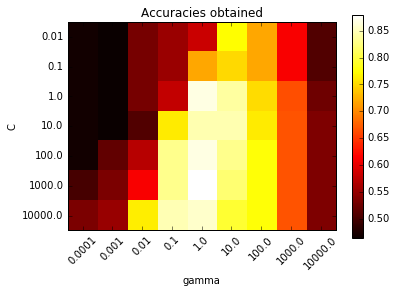

In [50]:
scores2=np.array([x[1] for x in gs_pipe.grid_scores_]).reshape(len(Cs),len(gammas))

plt.imshow(scores2, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), gammas, rotation=45)
plt.yticks(np.arange(len(Cs)), Cs)
plt.title('Accuracies obtained')
plt.show()

Yes, within the pipeline, we obtain differents resuts. We no longer overfit the model due to the feature selection from the pipeline

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Reprint the best parameters and their accuracy both on training and test. How did they change? Are they better now?
 </td></tr>
</table>

In [51]:

print("best Score Training", gs_pipe.best_score_)
print("Best parameters :")
print( gs_pipe.best_params_)
print("best Score Test:",gs_pipe.score(X_test, y_test))

best Score Training 0.88
Best parameters :
{'svm__gamma': 1.0, 'svm__C': 1000.0}
best Score Test: 0.948


/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
Accuracies do not tell you what the SVM is actually doing internally. Since the data are bidimensional, in this case we can plot what is going on. Write some code that calculates the SVM output (i.e., the distance to the hyperplane) for a mesh of points in the range of the inputs *X*. Your code should plot these distances, as well as the points *(X,y)* passed, using the color convention for the dataset: red for one class and blue for the other one. Explain with your own words the figure you obtain.
</td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
The distance to the hyperplane is computed by the SVC method **decision\_function(X)**, which is also part of the interface of scikit-learn's models. Your plot should look similar to the ones that appear in <a href=http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html>this example</a>. Feel free to base your code on the one appearing in the example.
 </td></tr>
</table>

/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


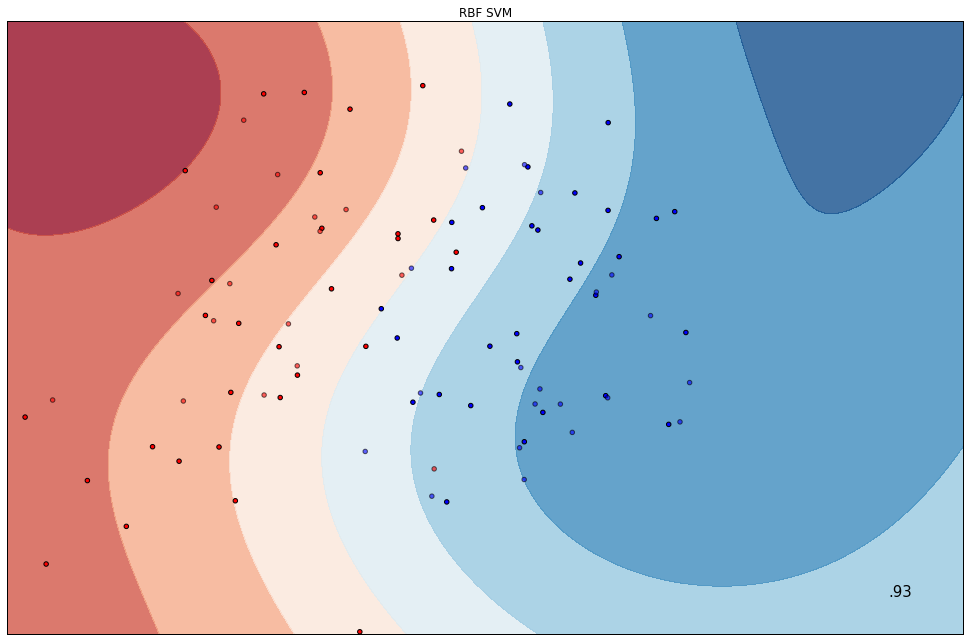

In [72]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["RBF SVM"]


figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets

 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


i += 1

# iterate over classifiers
ax = plt.subplot(1, 1 + 1, i)
score = gs_pipe.score(X_test, y_test)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(gs_pipe, "decision_function"):
    Z = gs_pipe.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = gs_pipe.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot also the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
  
ax.set_title(name)
ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
i += 1

plt.tight_layout()
plt.show()



## Training times

All the classes that scikit-learn provides for **non-linear SVMs** make use of **LIBSVM** internally. LIBSVM is regarded as the state-of-the-art piece of software for non-linear SVM training. It is based on the classical **SMO** algorithm.

SVMs are robust and have a very sound mathematical foundation. However, their main drawback in practical use is that, even if we use well-devised software to train them, the complexity is at least quadratic in the number of samples *n*. In big O notation, this is stated as **0(n<sup>2</sup>)**. This precludes the use of non-linear SVMs for very large datasets.

To illustrate this time growth, we will work with the *adult* dataset, available at the <a href=https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/>LIBSVM website</a>. There are 9 versions of this dataset with increasing training test sizes, ranging from roughly 1600 in the first one to more than 32000 in the last one. They have been downloaded for you in the *data* folder, under the names *adultX.svm*, where X ranges from 1 to 9.

Let us load for now the smallest version (*adult1.svm*). These .svm files have a special format to save space in disk. Fortunately, scikit-learn has some special functions to load this kind of files:

In [27]:
from sklearn.datasets import load_svmlight_file, load_svmlight_files

As their name makes clear, the first function loads a single file, whereas the second one can load several ones. In the particular case of *adult1.svm*, we want to load also the test set *adult1_test.svm* for parameter tuning, so we can write:

In [28]:
X_train, y_train, X_test, y_test = load_svmlight_files(("./data/adult1.svm", "./data/adult1_test.svm"))
print(X_train.shape)
print(X_test.shape)

(1605, 123)
(30956, 123)


As you can see, this dataset has 123 features. Grid search could take long, so here we will use **linear SVMs**. Recall that the default kernel function is RBF, so this has to be specified during construction of the SVC class:

In [29]:
SVC(kernel='linear')

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Thus, the *gamma* parameter will no longer be applicable, and the only parameter to tune is *C*. Let us use a narrower range now, as training tends to take a long time for large *C*: 

In [79]:
Cs = np.logspace(-3, 2, 6)

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Use the code of the previous section to tune a linear SVM on the *adult1* dataset.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
A pipeline with normalization is not necessary in this case, since all features of the dataset turn out to be binary and scales are not an issue. Thus, the estimator inside *GridSearchCV* should be just a linear SVM. 
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Since there is a single parameter *C* to optimize, *accs* should become now a vector instead of a matrix.
 </td></tr>
</table>

In [80]:
gs = GridSearchCV(estimator=SVC(kernel='linear'),
                          param_grid={ "C": [0.0001, 0.001, 0.01,0.1,1,10,100,1000,10000]}, # Y varios valores de la regularización C
                          scoring="roc_auc")# En vez dccuracy, vamos a usar el área bajo la curva ROC
                          

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Print the best *C* and its accuracy both on training and test. Verify that overfitting is not happening.
 </td></tr>
</table>

In [ ]:
gs.fit(X=X_train,y=y_train)

We will use this value of *C* for all versions of the *adult* dataset. In order to measure execution times, Python has the native function *time*:

In [113]:
gs.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [114]:
gs.best_score_

0.8824210148419052

In [115]:
gs.best_params_

{'C': 0.1}

In [116]:
from time import time

To measure how many seconds it takes to execute some code, place that code between two calls to *time* and measure the difference:

In [117]:
t_start = time()
for i in range(1000000):
    pass    # do nothing
t_end = time()
t_end - t_start

0.10391807556152344

One of the improvements of LIBSVM with respect to SMO is its **caching** strategy. For most real-life datasets, there are patterns that are ignored by LIBSVM since they do not influence the solution, whereas there are other patterns that are repeatedly optimized upon in several iterations. If we store in a cache the rows of the kernel matrix corresponding to these repeated patterns, we can save the time needed to recalculate them from scratch.

Obviously, the larger the cache is, the more rows it is able to store and the bigger its time-saving potential is. This size is controlled by the *cache_size* parameter of *SVC*, which defaults to 200 MB unless specified otherwise on construction:

In [118]:
best_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=100.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let us try with these sizes:

In [119]:
caches = [100, 200, 500]

Our goal is to plot training time versus number of patterns, repeating the process for these 3 cache sizes and the increasingly large *adult* versions. There are 9 of these, but we will work with just the first 6:

In [120]:
num_adults = 6

For example, for the default cache of 200 MB, the training time of the smallest *adult* version (the one currently loaded) is:

In [121]:
t_start = time()
best_model.fit(X_train, y_train)
t_end = time()
t = t_end - t_start
print((len(y_train), t))

(1605, 0.3380470275878906)


But this is is just a single point of the plot we want. Your task is to compute the training times for all combinations of cache sizes and *adult* versions, storing them in the following matrix:

In [122]:
times = np.zeros((num_adults, len(caches)))

Whereas the dataset sizes will be stored in the following vector:

In [123]:
sizes = np.zeros((num_adults, 1))

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Write the code that fills *times* and *sizes*.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
In order to minimize disk accesses, load each version of the *adult* dataset in an outer loop, and do the training for the different cache sizes in an inner loop.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Test sets are not needed, so it is enough to use *load_svmlight_file* to load the training sets.
 </td></tr>
</table>

In [140]:
files=["./data/adult1.svm","./data/adult2.svm","./data/adult3.svm","./data/adult4.svm","./data/adult5.svm","./data/adult6.svm"]


for i,file in enumerate(files):
    print("processing file..",file)
    X_train, y_train= load_svmlight_file(file)
    sizes[i]=len(y_train)

    for j,cache in enumerate(caches):
        print("fitting file:%s\tcache size:%d" %(file,cache))
        gs = GridSearchCV(estimator=SVC(kernel='linear',cache_size=cache),
                          param_grid={ "C": [0.1]}, # Y varios valores de la regularización C
                          scoring="roc_auc")# En vez dccuracy, vamos a usar el área bajo la curva ROC
                          
        t_start = time()
        gs.fit(X_train, y_train)
        t_end = time()
        t = t_end - t_start
        times[i,j]=t
        print((len(y_train), t))



processing file.. ./data/adult1.svm
fitting file:./data/adult1.svm	cache size:100
(1605, 0.32491540908813477)
fitting file:./data/adult1.svm	cache size:200
(1605, 0.3339717388153076)
fitting file:./data/adult1.svm	cache size:500
(1605, 0.32384562492370605)
processing file.. ./data/adult2.svm
fitting file:./data/adult2.svm	cache size:100
(2265, 0.6129529476165771)
fitting file:./data/adult2.svm	cache size:200
(2265, 0.6350936889648438)
fitting file:./data/adult2.svm	cache size:500
(2265, 0.6203446388244629)
processing file.. ./data/adult3.svm
fitting file:./data/adult3.svm	cache size:100
(3185, 1.133281946182251)
fitting file:./data/adult3.svm	cache size:200
(3185, 1.0915789604187012)
fitting file:./data/adult3.svm	cache size:500
(3185, 1.10430908203125)
processing file.. ./data/adult4.svm
fitting file:./data/adult4.svm	cache size:100
(4781, 2.412691354751587)
fitting file:./data/adult4.svm	cache size:200
(4781, 2.4045143127441406)
fitting file:./data/adult4.svm	cache size:500
(4781, 2.

At this point we have all the necessary information for plotting.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Use the code below to plots *times* versus *sizes*. What trend do you observe in the figure? Does this comply with the theoretical complexity? From what point does cache size begin to be relevant?
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
LIBSVM's complexity ranges from O(n<sup>2</sup>) to O(n<sup>3</sup>), depending on factors such as cache efficiency and the dataset itself. For example, the more features the dataset has, the longer training takes, since the complexity of computing the kernel function scales linearly with the number of features.
 </td></tr>
</table>

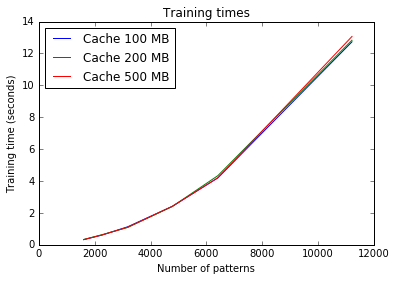

In [141]:
for i, c in enumerate(caches):
    plt.plot(sizes, times[:, i], label='Cache ' + str(c) + ' MB')
plt.xlabel('Number of patterns')
plt.ylabel('Training time (seconds)')
plt.legend(loc='best')
plt.title('Training times')
plt.show()

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
Complete your study with the largest versions (*adult7*, *adult8* and *adult9*) and an additional cache size of 1000 MB. Replot the results. Is the previous trend confirmed?
 </td></tr>
</table>

processing file.. ./data/adult1.svm
fitting file:./data/adult1.svm	cache size:100
(1605, 0.3267073631286621)
fitting file:./data/adult1.svm	cache size:200
(1605, 0.31730175018310547)
fitting file:./data/adult1.svm	cache size:500
(1605, 0.3293118476867676)
fitting file:./data/adult1.svm	cache size:1000
(1605, 0.31643152236938477)
processing file.. ./data/adult2.svm
fitting file:./data/adult2.svm	cache size:100
(2265, 0.629692792892456)
fitting file:./data/adult2.svm	cache size:200
(2265, 0.6319069862365723)
fitting file:./data/adult2.svm	cache size:500
(2265, 0.6799781322479248)
fitting file:./data/adult2.svm	cache size:1000
(2265, 0.6498541831970215)
processing file.. ./data/adult3.svm
fitting file:./data/adult3.svm	cache size:100
(3185, 1.0963270664215088)
fitting file:./data/adult3.svm	cache size:200
(3185, 1.09035062789917)
fitting file:./data/adult3.svm	cache size:500
(3185, 1.0850913524627686)
fitting file:./data/adult3.svm	cache size:1000
(3185, 1.0896644592285156)
processing fil

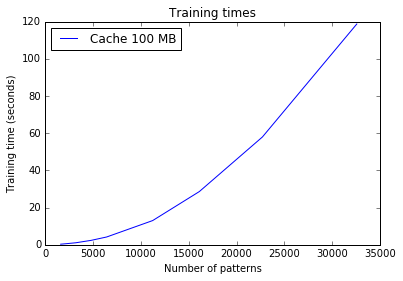

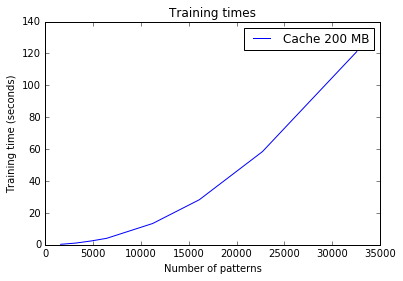

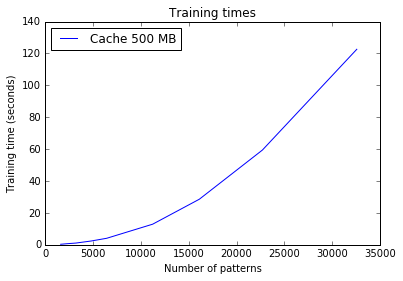

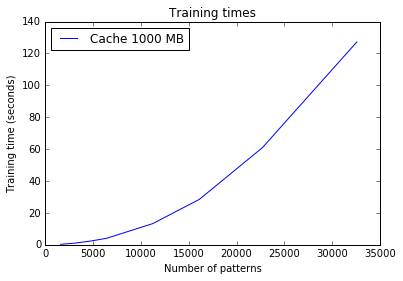

In [142]:
num_adults = 9
caches =[100,200,500,1000]
times = np.zeros((num_adults, len(caches)))
sizes = np.zeros((num_adults, 1))

files=["./data/adult1.svm",
       "./data/adult2.svm",
       "./data/adult3.svm",
       "./data/adult4.svm",
       "./data/adult5.svm",
       "./data/adult6.svm",
       "./data/adult7.svm",
       "./data/adult8.svm",
       "./data/adult9.svm"
      ]


for i,file in enumerate(files):
    print("processing file..",file)
    X_train, y_train= load_svmlight_file(file)
    sizes[i]=len(y_train)

    for j,cache in enumerate(caches):
        print("fitting file:%s\tcache size:%d" %(file,cache))
        gs = GridSearchCV(estimator=SVC(kernel='linear',cache_size=cache),
                          param_grid={ "C": [0.1]}, # Y varios valores de la regularización C
                          scoring="roc_auc")# En vez dccuracy, vamos a usar el área bajo la curva ROC
                          
        t_start = time()
        gs.fit(X_train, y_train)
        t_end = time()
        t = t_end - t_start
        times[i,j]=t
        print((len(y_train), t))
        
        
for i, c in enumerate(caches):
    plt.plot(sizes, times[:, i], label='Cache ' + str(c) + ' MB')
    plt.xlabel('Number of patterns')
    plt.ylabel('Training time (seconds)')
    plt.legend(loc='best')
    plt.title('Training times')
    plt.show()


<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Because of time complexity, it may well be the case that these large datasets take a long time to train (minutes or even hours, depending on your computer). Use traces in your code to make sure everything is going fine.
 </td></tr>
</table>

This time growth always happens with non-linear SVMs, even if we use the best algorithms available. Note however that we have been experimenting with a linear SVM. For linear SVMs there are more efficient solvers for large datasets, based on techniques like coordinate gradient descent (LIBLINEAR) or stochastic gradient descent (Pegasos). Scikit-learn knows about this, and provides a specific implementation for a linear SVM that invokes LIBLINEAR called <a href=http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html>LinearSVC</a>:

In [143]:
from sklearn.svm import LinearSVC
LinearSVC()

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Note that there is no cache parameter now, since LIBLINEAR does not make use of a cache. On the other hand, LIBLINEAR is a flexible algorithm that can be used to train other models different than SVMs. To make it train an actual SVM, it must be constructed with *loss='hinge'*. Besides, since it has a random component, we will make use of *RND_STATE*. The rest of parameters are fine with their defaults:

In [146]:
linearsvc=LinearSVC(loss='hinge', random_state=RND_STATE)

Since this class takes a lot less time to train, we can now use all 9 versions of the *adult* dataset. As there is no cache now, we should reshape *times* to vector form:

In [145]:
num_adults = 9
times = np.zeros((num_adults, 1))
sizes = np.zeros((num_adults, 1))


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Rewrite the code that fills *times* and *sizes*, using now a *LinearSVC* instance instead of an *SVC* one.
 </td></tr>
</table>

In [148]:
num_adults = 9
caches =[100,200,500,1000]
times = np.zeros((num_adults, len(caches)))
sizes = np.zeros((num_adults, 1))

files=["./data/adult1.svm",
       "./data/adult2.svm",
       "./data/adult3.svm",
       "./data/adult4.svm",
       "./data/adult5.svm",
       "./data/adult6.svm",
       "./data/adult7.svm",
       "./data/adult8.svm",
       "./data/adult9.svm"
      ]


for i,file in enumerate(files):
    print("processing file..",file)
    X_train, y_train= load_svmlight_file(file)
    sizes[i]=len(y_train)
    print("fitting file:%s" %file)
    t_start = time()
    linearsvc.fit(X_train, y_train)
    t_end = time()
    t = t_end - t_start
    times[i]=t
    print((len(y_train), t))
        
        



processing file.. ./data/adult1.svm
fitting file:./data/adult1.svm
(1605, 0.014275789260864258)
processing file.. ./data/adult2.svm
fitting file:./data/adult2.svm
(2265, 0.01444387435913086)
processing file.. ./data/adult3.svm
fitting file:./data/adult3.svm
(3185, 0.02060699462890625)
processing file.. ./data/adult4.svm
fitting file:./data/adult4.svm
(4781, 0.025623559951782227)
processing file.. ./data/adult5.svm
fitting file:./data/adult5.svm
(6414, 0.041970252990722656)
processing file.. ./data/adult6.svm
fitting file:./data/adult6.svm
(11220, 0.07304573059082031)
processing file.. ./data/adult7.svm
fitting file:./data/adult7.svm
(16100, 0.10940432548522949)
processing file.. ./data/adult8.svm
fitting file:./data/adult8.svm
(22696, 0.1700136661529541)
processing file.. ./data/adult9.svm
fitting file:./data/adult9.svm
(32561, 0.3078031539916992)


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Plot the times obtained versus the training set sizes. Compare this figure with the one you got for the *SVC* class. What is the time complexity for *LinearSVC*?
 </td></tr>
</table>

time complexity: O(n2)

/home/bellinsky/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


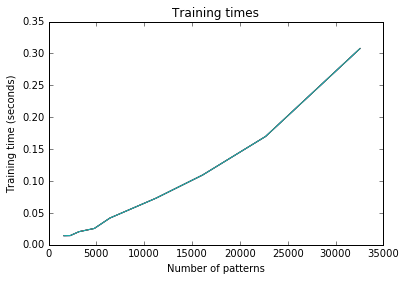

In [149]:
plt.plot(sizes, times)
plt.xlabel('Number of patterns')
plt.ylabel('Training time (seconds)')
plt.legend(loc='best')
plt.title('Training times')
plt.show()

## Custom kernels

To conclude this assignment, we will deal with custom kernels for non-numerical data. 

As we saw in the pipelining section, scikit-learn implements several transformers that help in adapting data to the specific needs of the different estimators. However, these are usually numerical transformations. What if the data we want to work with are non-numerical, such as images or texts? Good news: scikit-learn also provides transformer classes for these kinds of data. 

In this exercise, we will concentrate on texts. Texts are problematic not only because they are non-numeric, but also because they typically have different lengths, punctuation marks, uppercase and lowercase letters, etcetera. The most common strategy in <a href=http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction>text preprocessing</a> is to transform a series of texts (**corpus**) into a **bag-of-words** representation. In plain language, this means:

* Standardizing all texts in the corpus into a common form (e.g., lowercase with punctuation removed).
* Splitting them in different units called **tokens** (e.g., words).
* Counting how many times each token appears.

Thus, each text will be transformed into a vector of length *d*, where *d* is the number of different tokens in the corpus. Its i-th element will be the number of times the i-th token appears in the text. This transformation is carried out by the <a href=http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html>CountVectorizer</a> class:

In [331]:
from sklearn.feature_extraction.text import CountVectorizer
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

By default we can see that it tokenizes texts into lowercase words. Let us illustrate how it works with a simple corpus with 3 short texts:

In [332]:
corpus = ['This is the first text.', 'This is the second text.', 'And yet another text: the third text.']

Fitting this corpus splits the different words, which are available in the *vocabulary\_* attribute:

In [333]:
cvec = CountVectorizer().fit(corpus)
cvec.vocabulary_

{'and': 0,
 'another': 1,
 'first': 2,
 'is': 3,
 'second': 4,
 'text': 5,
 'the': 6,
 'third': 7,
 'this': 8,
 'yet': 9}

We can see that the i-th position of each word is determined by alphabetical order and that punctuation has been removed. The transformed texts will thus be:

In [334]:
X = cvec.transform(corpus)
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

They are stored in a **sparse** matrix X, which only stores the words present. For example, the third text (that with index 2) is:

In [335]:
print(X[2,:])

  (0, 0)	1
  (0, 1)	1
  (0, 5)	2
  (0, 6)	1
  (0, 7)	1
  (0, 9)	1


That is, it has 2 occurrences of the 5-th word in the vocabulary ('text'), and 1 ocurrence of the 0-th, 1-st, 6-th, 7-th and 9-th words ('and', 'another', 'the', 'third' and 'yet'). Words not occurring have a count of 0 and they are not stored in *X* to save space. This sparse format may seem cumbersome for this little example, but it is very compact for extensive corpuses that yield large vocabularies. Usually each text (usually called **document**) will have only a few words from the whole vocabulary, so most of its features will be 0 and there is no need to store that. 

For example, the *20 newsgroups* dataset available in scikit-learn has 18000 documents. It can be loaded with the following utility function:

In [336]:
from sklearn.datasets import fetch_20newsgroups

The documents are pieces of news belonging to 20 categories. Here we will only use 2 of them (atheism and religion) in order to cast a binary classification problem. The source file is available in the *data* folder. Let us load the training data, which has 857 documents (480 talking about atheism, 377 about religion):

In [337]:
categories=['alt.atheism', 'talk.religion.misc']
data = fetch_20newsgroups(subset='train', categories=categories, data_home="./data", 
                          download_if_missing=False, random_state=RND_STATE)
X_train, y_train = data.data, data.target
print(data.target_names)
print(len(X_train))
print(sum(y_train == 0))
print(sum(y_train == 1))


['alt.atheism', 'talk.religion.misc']
857
480
377


A document looks like this:

In [236]:
X_train[0]

'From: david@terminus.ericsson.se (David Bold)\nSubject: No News Is Bad News\nReply-To: david@terminus.ericsson.se\nDistribution: world\nOrganization: Camtec Electronics (Ericsson), Leicester, England\nLines: 20\nNntp-Posting-Host: bangkok\n\nI\'m having trouble receiving News at the moment due to an overloaded\nNews server. I think that I can post out reasonably quickly, though.\n\nI\'m in a couple of threads at the moment which may be pending replies.\nIf anyone wants a reply from me over something I\'ve posted then I\nsuggest sending an e-mail copy of the point to me so that I can reply by\nNews.\n\nThis is one way to shut me up!!\n\nCheers,\n\nDavid.\n\n---\nOn religion:\n\n"Oh, where is the sea?", the fishes cried,\nAs they swam its clearness through.\n\n'

Note all the punctuation marks, whitespaces, linebreaks... Fortunately, *CountVectorizer* will take care of all that internally and will transform *X_train* into a numerical matrix suitable for an SVM. There are 3 possibilities for this SVM:
* A linear SVM.
* A non-linear SVM with some existing kernel (e.g., RBF).
* A non-linear SVM with a custom kernel for this task.

We covered the first 2 kinds of SVMs in the previous sections, so let us consider the third one. The class *SVC* allows to specify a user-defined function for the *kernel* attribute. The <a href=http://scikit-learn.org/stable/modules/svm.html#svm-kernels>documentation</a> specifies that your custom kernel must take as arguments 2 matrices of shape (n1, d), (n2, d) and return a kernel matrix of shape (n1, n2).

Recall that a kernel measures similarity between patterns. Since our patterns will be word counts, we should do some operation that measures how similar two documents are, using their word-count vectors. A possibility that comes to mind is to count **how many words appear in both documents**. The following function calculates this:

In [338]:
def words_in_common(X1, X2):
    X1_bin = (X1 > 0).astype(np.int)     # binarize word counts in corpus X1: 1 = word appears, 0 = word does not appear
    X2_bin = (X2 > 0).astype(np.int)     # same for second corpus X2
    # Now, for two documents in binary vector form, the number of matching words is the sum of 1s in the same positions.
    # For example, [0, 1, 1, 0] and [1, 1, 1, 0] have two 1s in the same position (2nd and 3rd), so they have 2 words in common.
    # Observation: this is the same as the sum of the dot product of both vectors.
    # Thus, in matrix form we just have to transpose the second corpus, and call standard matrix multiplication.
    return X1_bin.dot(X2_bin.T)

Let us verify it works as expected:

In [339]:
print(words_in_common(X, X))

  (0, 2)	2
  (0, 1)	4
  (0, 0)	5
  (1, 2)	2
  (1, 1)	5
  (1, 0)	4
  (2, 1)	2
  (2, 0)	2
  (2, 2)	6


Obviously, each document has all words in common with itself. The first one has 4 words in common with the second one (they only differ in the words 'first' and 'second'). The remaining cells are also correct, and the resulting matrix is symmetric, as every kernel matrix should be.

Now we are ready to try a pipeline with a *CountVectorizer* and an SVM with this custom kernel. We will use the same values for *C* than in the previous exercise.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Build the pipeline and optimize it with grid search, as you did in the previous sections.
 </td></tr>
</table>

In [340]:
count_vectorizer = CountVectorizer()
clf = SVC(kernel=words_in_common)

mypipeline = Pipeline(steps=[("countvectorizer", count_vectorizer),
                                   ("svm", clf)])

gs= GridSearchCV(estimator=mypipeline,
                      param_grid={"svm__C": Cs},                                             
                      scoring="accuracy",
                      cv=5,
                      verbose=1)

gs.fit(X_train,y_train)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   25.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ..., max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Report the value of *C* obtained, as well as the accuracies on training and test. How good are they?
 </td></tr>
</table>

In [341]:
gs.best_params_

{'svm__C': 0.10000000000000001}

In [342]:
gs.best_score_

0.941656942823804

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
You will need to load the test data. Load them like the training data.
 </td></tr>
</table>

In [343]:
categories=['alt.atheism', 'talk.religion.misc']
data = fetch_20newsgroups(subset='test', categories=categories, data_home="./data", 
                          download_if_missing=False, random_state=RND_STATE)
X_test, y_test = data.data, data.target
print(data.target_names)
print(len(X_test))
print(sum(y_test == 0))
print(sum(y_test == 1))

gs.score(X_test,y_test)


['alt.atheism', 'talk.religion.misc']
570
319
251


/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.80175438596491233

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
One problem with the kernel *words_in_common* is that the information about how many times each word appears is lost. For example, if a given word W appears in a document D1 twice and in another document D2 just once, both documents are considered to match 100% for W. The same happens if that word appears twice both in D1' and D2'. In terms of similarity, though, it seems natural to consider that D1' and D2' are more similar for W than D1 and D2. A measure that takes this into account is the <a href=https://en.wikipedia.org/wiki/Cosine_similarity>cosine similarity</a>, defined as **u<sup>T</sup>v / (||u||*||v||)**, where **u** and **v** are the word-count vectors for both documents and **||·||** stands for the L2 norm. Define a function that implements cosine similarity, and tune the resulting pipeline. Can you obtain better results with this kernel?
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Recall that ||u|| = sqrt(u<sup>T</sup>u). Thus, you can implement this kernel in terms of numpy's *dot* function. Scikit-learn's function <a href=http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html>normalize</a> can also be helpful.
 </td></tr>
</table>

In [344]:
from sklearn.preprocessing import normalize
def words_in_common_pro(X1, X2):
    X1_bin = (X1 > 0).astype(np.int)     # binarize word counts in corpus X1: 1 = word appears, 0 = word does not appear
    X2_bin = (X2 > 0).astype(np.int)     # same for second corpus X2
    # Now, for two documents in binary vector form, the number of matching words is the sum of 1s in the same positions.
    # For example, [0, 1, 1, 0] and [1, 1, 1, 0] have two 1s in the same position (2nd and 3rd), so they have 2 words in common.
    # Observation: this is the same as the sum of the dot product of both vectors.
    # Thus, in matrix form we just have to transpose the second corpus, and call standard matrix multiplication.
    X1_norm=normalize(X1_bin)
    X2_norm=normalize(X2_bin)
    return X1_norm.dot(X2_norm.T)

print(words_in_common_pro(X, X))

count_vectorizer = CountVectorizer()
clf = SVC(kernel=words_in_common_pro)

mypipeline = Pipeline(steps=[("countvectorizer", count_vectorizer),
                                   ("svm", clf)])

gs= GridSearchCV(estimator=mypipeline,
                      param_grid={"svm__C": Cs},                                             
                      scoring="accuracy",
                      cv=5,
                      )

gs.fit(X_train,y_train)

print(gs.best_params_)

print(gs.best_score_)


/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


  (0, 2)	0.36514837167
  (0, 1)	0.8
  (0, 0)	1.0
  (1, 2)	0.36514837167
  (1, 1)	1.0
  (1, 0)	0.8
  (2, 1)	0.36514837167
  (2, 0)	0.36514837167
  (2, 2)	1.0


/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklear

{'svm__C': 10.0}
0.9463243873978997


/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [345]:
gs.score(X_test,y_test)

/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


0.81578947368421051

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
Compare your results with the ones obtained by a linear SVM. Even if linear SVMs tend to give worse results, they have the advantage of the model's interpretability. Since the weight vector **w** does not depend on an unknown feature map, we can retrieve it after training. Moreover, because the decision function is **w·x + b** and one class is positive (y = +1) and the other is negative (y = -1), the components of **w** can be interpreted as the importance of the variables **x**: the more positive the i-th component of **w**, the more related is that variable to the positive class. Conversely, the more negative, the more related to the negative class. In this particular case, the features **x** are word counts, so the sign of **w** gives us how much a word indicates atheism (positive class) or religion (negative class). Once you have tuned your linear SVM, find the 10 most indicative words for each class. Do they make sense?
 </td></tr>
</table>

In [346]:
count_vectorizer = CountVectorizer()
clf = SVC(kernel='linear')

mypipeline = Pipeline(steps=[("countvectorizer", count_vectorizer),
                                   ("svm", clf)])

gs= GridSearchCV(estimator=mypipeline,
                      param_grid={"svm__C": Cs},                                             
                      scoring="accuracy",
                      cv=5,
                      )

gs.fit(X_train,y_train)

print(gs.best_params_)

print(gs.best_score_)



{'svm__C': 0.01}
0.9369894982497082


In [347]:
gs.score(X_test,y_test)

/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.79649122807017547

In [356]:
best_svm = gs.best_estimator_.named_steps['svm']
coef_dense=best_svm.coef_.todense()
print(coef_dense)

[[ 0.01042025 -0.02594796  0.         ..., -0.0028132   0.00750738
   0.00750738]]


<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
**w** is available in the *coef\_* attribute of the SVM. Since it is stored as a sparse matrix, you will need to transform it into a dense vector.
 </td></tr>
</table>

In [397]:
index=np.argsort(coef_dense)
column,rows=index.shape


<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Once you retrieve **w**, you can find its largest and smallest components with numpy's *argsort* function. Note that the *CountVectorizer*'s *vocabulary_* attribute is in dictionary form, so you cannot find the words from their indices. Use instead the word list returned by the method *get_feature_names* of the *CountVectorizer* class.
</td></tr>
</table>

In [398]:
countvectorizer=gs.best_estimator_.named_steps["countvectorizer"]
word_list=countvectorizer.get_feature_names()

#imprimimos la primera y la ultima palabra, segun el valor de los w
print(word_list[index[0,0]])
print(word_list[index[0,rows-1]])

#oredenamos la lista segun los indices de las palabras mas repetiddas
list_index=np.array(index)[0].tolist()
word_list_sort = [word_list[i] for i in list_index]

print(word_list_sort)

atheists
christian
['atheists', 'keith', 'atheism', 'wingate', 'free', 'caltech', 'cobb', 'okcforum', 'freedom', 'uk', 'thing', 'edu', 'mangoe', 'ibm', 'bill', 'dan', 'osrhe', 'genocide', 'tek', 'benedikt', 'umd', 'islamic', 'rushdie', 'charley', 'book', 'go', 'their', 'jaeger', 'cmu', 'tammy', 'mathew', 'wwc', 'example', 'au', 'pope', 'up', 'always', 'jon', 'him', 'saturn', 'fi', 'psilink', 'believing', 'maddi', 'political', 'peace', 'little', 'religious', 'it', 'bu', 'vice', 'ico', 'notion', 'agency', 'bobbe', 'beauchaine', 'atheist', 'princeton', 'post', 'germany', 'faq', '30', 'been', 'writes', 'dlb', 'conner', 'bible', 'was', 'ac', 'at', 'california', 'psuvm', 'therefore', 'more', 'abo', 'technology', 'guess', 'cco', 'bmd', 'trw', 'lis', 'alexia', 'strom', 'cannot', '12', 'batman', 'khan', 'lunatic', 'compaq', 'perfect', 'which', 'thoughts', 'from', 'hausmann', 'p00261', 'eternal', 'wesleyan', 'almost', '11', 'illinois', 'bobby', 'cause', 'claim', 'natural', 'around', 'schneider',

<center>
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.<br>
                          THIS IS THE END OF THE ASSIGNMENT<br>
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.<br>
</center>